In [1]:
import scvelo as scv
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import sys
from transpa.util import expVeloImp
import torch
import warnings

warnings.filterwarnings('ignore')

seed = 10
device = torch.device("cuda:3") if torch.cuda.is_available() else torch.device("cpu")
# load preprocessed scRNA-seq and spatial datasets
RNA = scv.read('../data/Chicken_heart/RNA_D14_adata.h5ad')
Visium = scv.read('../data/Chicken_heart/Visium_D14_adata.h5ad')

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [2]:
RNA, Visium

(AnnData object with n_obs × n_vars = 3009 × 10143
     obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.5', 'seurat_clusters', 'scanorama_snn_res.0.5', 'scanorama_snn_res.0.4', 'scanorama_snn_res.0.3', 'scanorama_snn_res.0.25', 'scanorama_snn_res.0.2', 'day', 'ventricle', 'celltypes.0.5', 'n_counts'
     var: 'gene_ids', 'n_cells', 'gene_count_corr'
     layers: 'spliced', 'unspliced',
 AnnData object with n_obs × n_vars = 1967 × 12295
     obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'percent.mito', 'Spatial_snn_res.1', 'seurat_clusters', 'scanorama_snn_res.1', 'Cardiomyocytes-1', 'Cardiomyocytes-2', 'Immature.myocardial.cells', 'Valve.cells', 'Macrophages', 'Fibroblast.cells', 'Erythrocytes', 'Endocardial.cells', 'MT-enriched.cardiomyocytes', 'Epi-epithelial.cells', 'Vascular.endothelial.cells', 'TMSB4X.high.cells', 'Epi-mesenchymal.cells', 'Dendritic.cells', 'Mural.cells', 'max', 'celltype_prediction_max', 

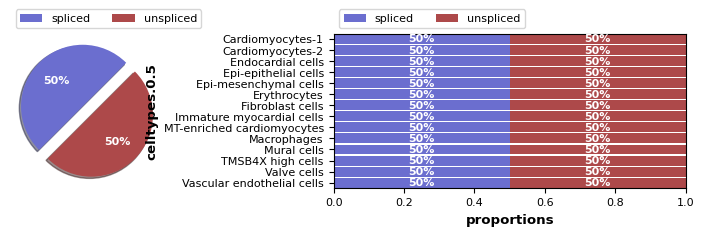

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Extracted 9927 highly variable genes.


In [3]:
scv.pl.proportions(RNA, 'celltypes.0.5')
scv.pp.filter_and_normalize(RNA, n_top_genes=2000, retain_genes=Visium.var_names)

In [4]:
scv.pp.moments(RNA, n_pcs=30, n_neighbors=30)
sc.tl.umap(RNA)

scv.tl.velocity(RNA, vkey='stc_velocity')
scv.tl.velocity_graph(RNA, vkey='stc_velocity', n_jobs=10)


computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 10/40 cores)


  0%|          | 0/3009 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [5]:
 pallete = dict(zip(RNA.obs["celltypes.0.5"].unique().tolist(), ['#123fa5',
 '#7d87b9',
 '#bec1d4',
 '#d6bcc0',
 '#bb7784',
 '#8e063b',
 '#4a6fe3',
 '#8595e1',
 '#b5bbe3',
 '#e6afb9',
 '#ff0000',
 '#d33f6a',
 '#11c638',
 '#8dd593']))
 pallete

{'Mural cells': '#123fa5',
 'TMSB4X high cells': '#7d87b9',
 'Fibroblast cells': '#bec1d4',
 'Vascular endothelial cells': '#d6bcc0',
 'Cardiomyocytes-1': '#bb7784',
 'Endocardial cells': '#8e063b',
 'Erythrocytes': '#4a6fe3',
 'Immature myocardial cells': '#8595e1',
 'Macrophages': '#b5bbe3',
 'Cardiomyocytes-2': '#e6afb9',
 'Epi-epithelial cells': '#ff0000',
 'Epi-mesenchymal cells': '#d33f6a',
 'MT-enriched cardiomyocytes': '#11c638',
 'Valve cells': '#8dd593'}

In [6]:
np.unique(RNA.obs["celltypes.0.5"], return_counts=True)

(array(['Cardiomyocytes-1', 'Cardiomyocytes-2', 'Endocardial cells',
        'Epi-epithelial cells', 'Epi-mesenchymal cells', 'Erythrocytes',
        'Fibroblast cells', 'Immature myocardial cells',
        'MT-enriched cardiomyocytes', 'Macrophages', 'Mural cells',
        'TMSB4X high cells', 'Valve cells', 'Vascular endothelial cells'],
       dtype=object),
 array([ 439,   25,   78,    2,    2,   60, 1292,   59,    3,   44,  248,
         355,    2,  400]))

computing velocity embedding
    finished (0:00:01) --> added
    'stc_velocity_pca', embedded velocity vectors (adata.obsm)


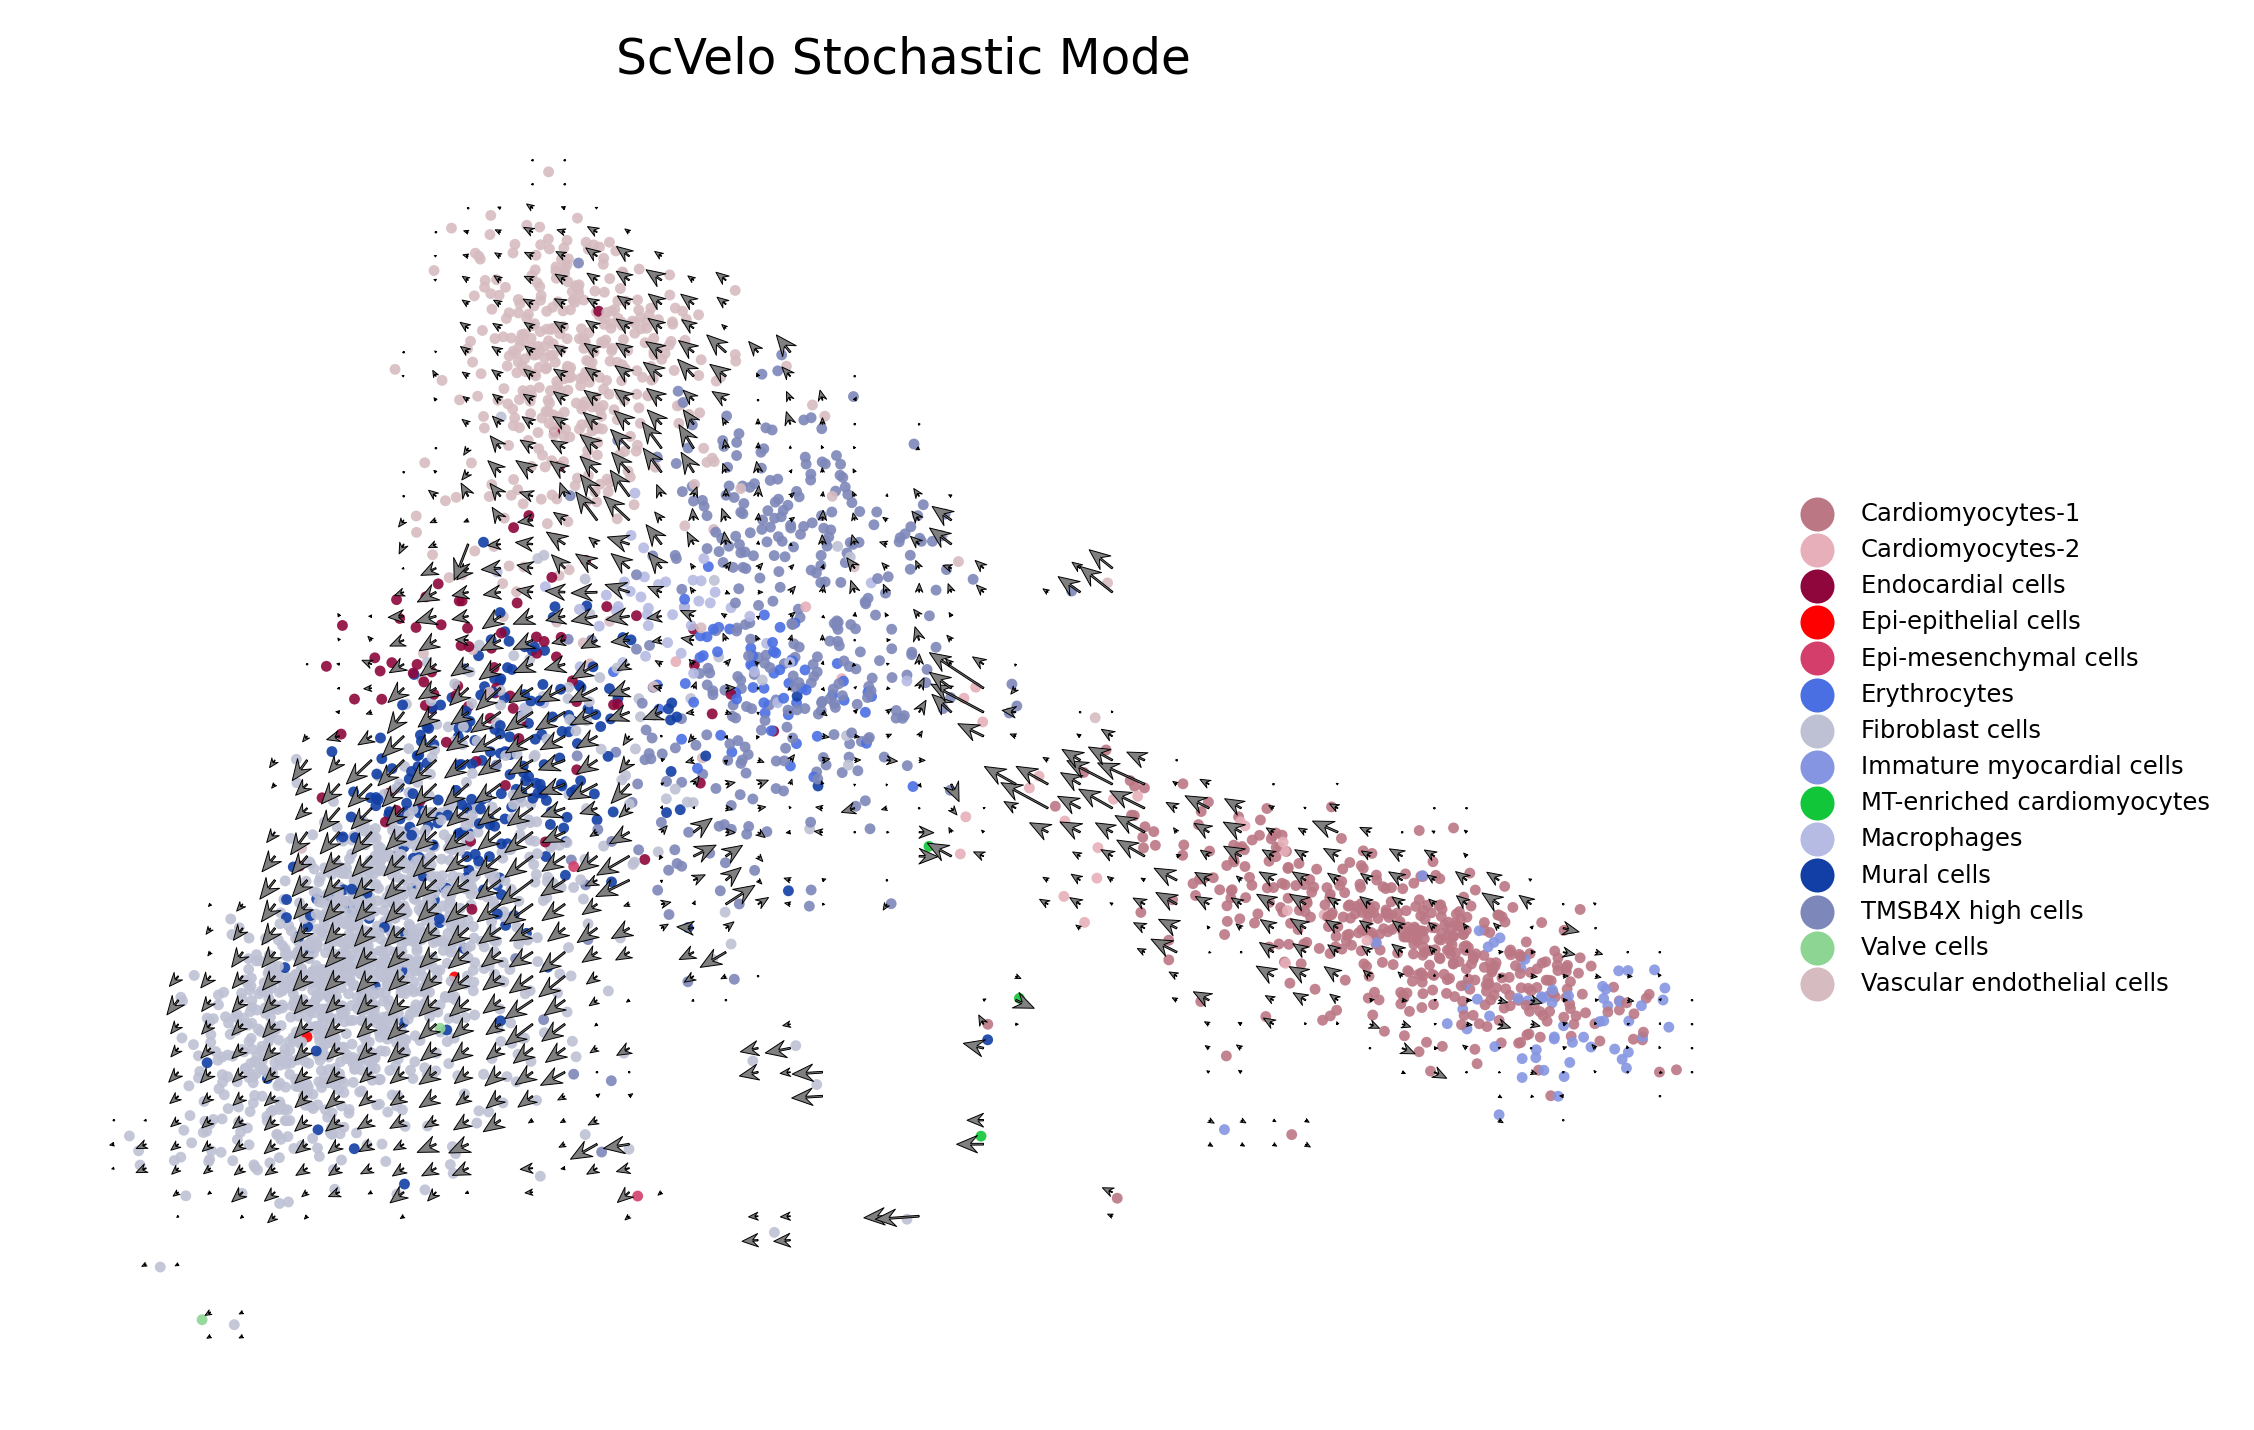

In [7]:
scv.pl.velocity_embedding_grid(RNA,  
                                vkey="stc_velocity", 
                                basis='X_pca', color="celltypes.0.5",
                                legend_fontsize=5,
                                size=20,
                                legend_loc='right',
                                palette=pallete,
                                dpi=350,
                                alpha=0.9,
                                arrow_length=2,
                                arrow_size=2,
                                title='ScVelo Stochastic Mode')

In [8]:
import squidpy as sq
Visium.obsm['spatial'] = Visium.obsm['X_xy_loc'] @ np.array([[-1,0],[0,-1]])
sq.gr.spatial_neighbors(Visium, coord_type='grid', n_neighs = 6)


In [9]:
import pandas as pd
raw_spatial_df  = pd.DataFrame(Visium.X, columns=Visium.var_names)
raw_scrna_df    = pd.DataFrame(RNA.X.toarray(), columns=RNA.var_names).astype(pd.SparseDtype("float32", 0))
raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((1967, 12295), (3009, 9927), (9836,))

In [10]:
S, U, V, X = expVeloImp(
            df_ref=raw_scrna_df,
            df_tgt=raw_spatial_df,
            S=RNA.layers['spliced'],
            U=RNA.layers['unspliced'],
            V=RNA.layers['spliced'],
            train_gene=raw_shared_gene,
            test_gene=RNA.var_names,
            signature_mode='cell',
            mapping_mode='lowrank', 
            mapping_lowdim=128,  
            spa_adj=Visium.obsp['spatial_connectivities'].tocoo(),
            n_epochs=1000,
            seed=seed,
            device=device)

[TransImp] Epoch: 1000/1000, loss: 0.767012, (IMP) 0.765921, (SPA) 1.0 x 0.001090: 100%|██████████| 1000/1000 [00:33<00:00, 30.19it/s]


In [11]:
imp_adata = sc.AnnData(X)
imp_adata.obs = Visium.obs.copy()
imp_adata.obsm = Visium.obsm.copy()
imp_adata.var_names = RNA.var_names
imp_adata.obs_names = Visium.obs_names
imp_adata.uns = Visium.uns

imp_adata.layers['spliced'] = S
imp_adata.layers['unspliced'] = U
# imp_adata.layers['velocity'] = V

scv.pp.normalize_per_cell(imp_adata, enforce=True)
sc.pp.scale(imp_adata)
sc.tl.pca(imp_adata)

sc.pp.neighbors(imp_adata, n_neighbors=30, n_pcs=20)
sc.tl.umap(imp_adata)
sc.tl.leiden(imp_adata, random_state=42)


scv.pp.moments(imp_adata, n_pcs=20, n_neighbors=30)
scv.tl.velocity(imp_adata, vkey='stc_velocity')
scv.tl.velocity_graph(imp_adata, vkey='stc_velocity', n_jobs=10)
scv.tl.velocity_confidence(imp_adata, vkey='stc_velocity')

Normalized count data: X, spliced, unspliced.
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 10/40 cores)


  0%|          | 0/1967 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)


Renamed 'rot_loc' to convention 'X_rot_loc' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_rot_loc', embedded velocity vectors (adata.obsm)


<Figure size 2800x8400 with 0 Axes>

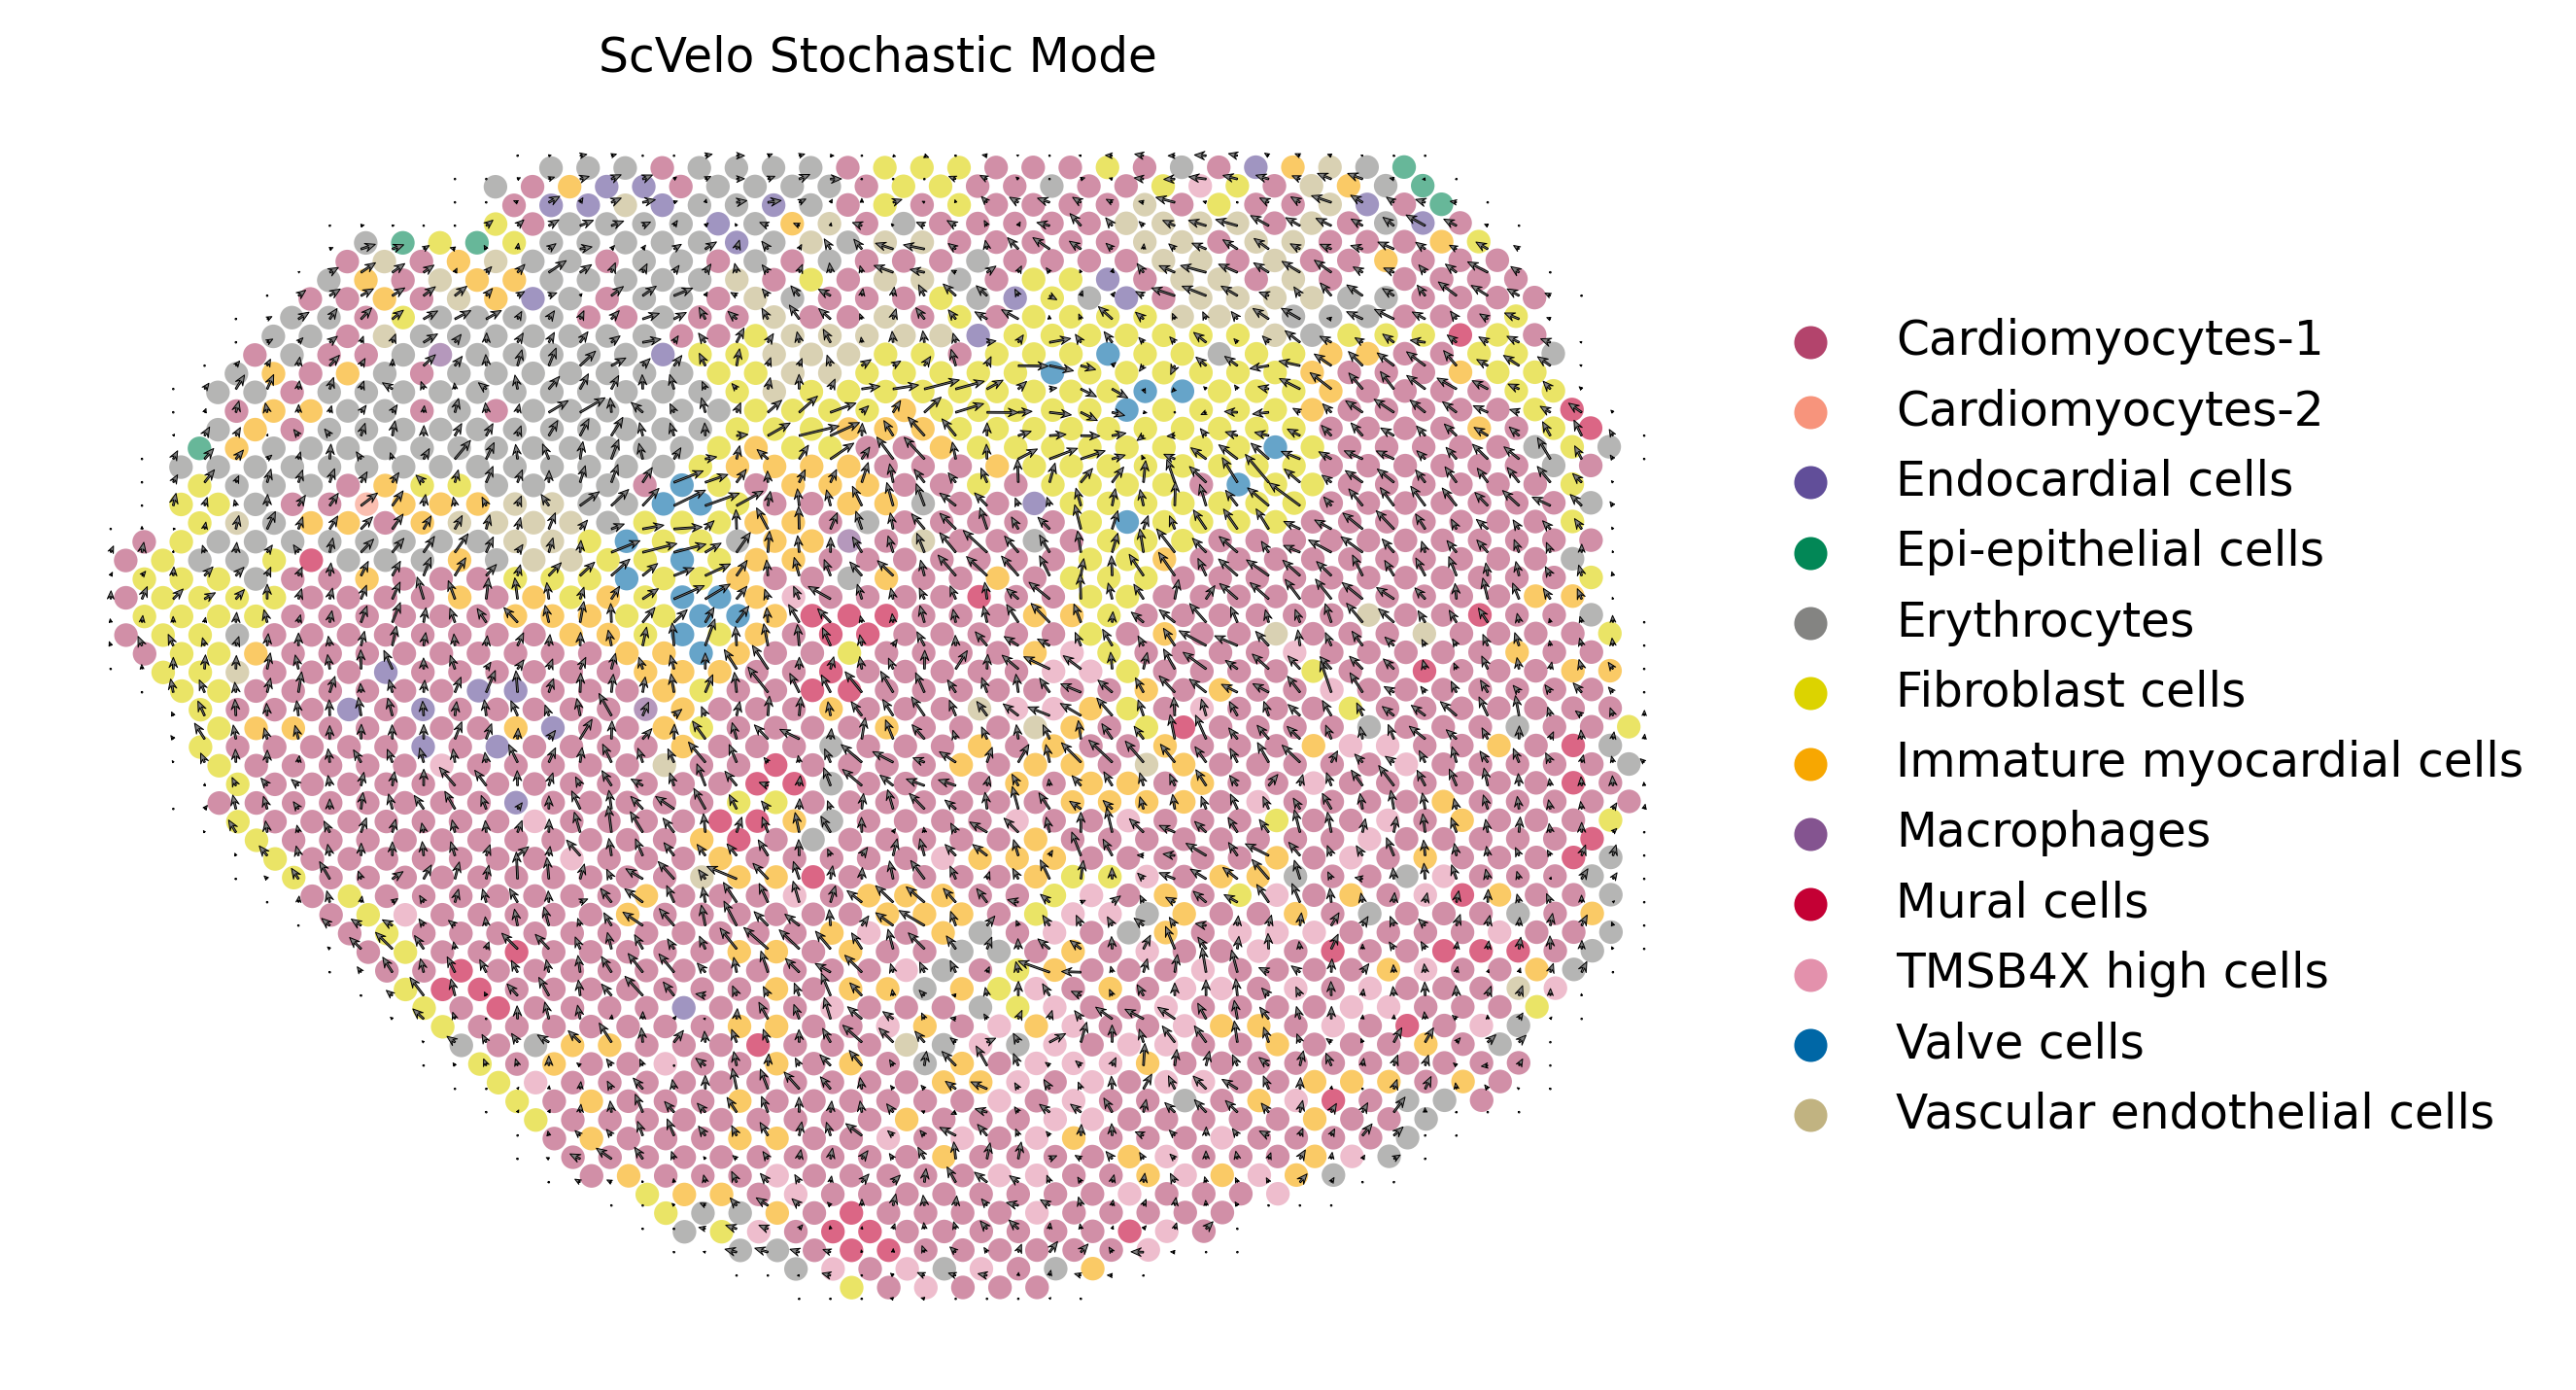

In [12]:
from matplotlib.pyplot import figure
figure(figsize=(8, 24), dpi=350)
imp_adata.obsm['rot_loc'] = imp_adata.obsm['spatial'] @ np.array([[1, 0],[0, -1]])
scv.pl.velocity_embedding_grid(imp_adata,  
                                vkey="stc_velocity", 
                                basis='rot_loc', color="celltype_prediction",
                                # legend_fontsize=60,
                                arrow_length=1.5,
                                arrow_size=1,
                                alpha=0.6,
                                size=100,
                                smooth=0.5,
                                legend_loc='right',
                                dpi=350,                                 
                                title='ScVelo Stochastic Mode')
                             